In [1]:
import os, math,time
import matplotlib.pyplot as plt
import numpy as np

from silence_tensorflow import silence_tensorflow
silence_tensorflow("ERROR")
import tensorflow as tf
import keras

gpuDevices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpuDevices))
tf.config.experimental.set_memory_growth(gpuDevices[0], True)
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})


import tensorflow_model_optimization as tfmot

I0000 00:00:1726143131.102510   11834 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726143131.137789   11834 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726143131.139429   11834 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Num GPUs Available:  1


In [2]:
batch_size = 32
image_shape = (40,160,1)
code_length = 4
lr=0.01
test_split = 0.2
validation_split=0.1
charset_length = 10
shuff_size =20000
epochs=60

loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_metric = keras.metrics.CategoricalAccuracy(name='train_accuracy')

I0000 00:00:1726143131.552968   11834 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726143131.554394   11834 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726143131.555626   11834 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726143131.668399   11834 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
def get_shape(ds:tf.data.Dataset):
    for image, label in ds.unbatch().take(1): # type: ignore
        tf.print("image:")
        tf.print(tf.shape(image))
        tf.print(image.dtype)
        tf.print("label:")
        tf.print(tf.shape(label))
        tf.print(label.dtype)
        # print("Single label:", label.numpy())

def decode_one_hot(one_hot_label: tf.Tensor) ->  tf.Tensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [code_length, charset_length])
    digits = tf.argmax(one_hot_reshaped, axis=-1)
    return tf.strings.reduce_join(tf.strings.as_string(digits), axis=0)
    

def decode_one_hot_2dim(one_hot_label : tf.Tensor) ->  tf.RaggedTensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [code_length, charset_length])
    return tf.argmax(one_hot_reshaped, axis=1)


def viz_ds(ds:tf.data.Dataset, count=6):
    plt.figure()
    ds= ds.unbatch().take(count)
    dsit = iter(ds)
    for i in range(count):
        image, label  = next(dsit)  # type: ignore
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"),cmap="gray")
        if (len(label.numpy().shape) == 2):
             plt.title(np.array2string(decode_one_hot_2dim(label).numpy()))
        else:
            plt.title(label.numpy())
            
        plt.tight_layout()
        plt.axis("off")

def get_label(file_path: tf.Tensor):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.strings.split(parts[-1], ".")[0]

def label_to_one_hot_2d(label:tf.Tensor) -> tf.Tensor:
    digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
    one_hot_digits = tf.one_hot(digits, depth=10)
    return one_hot_digits

def decode_img(img: tf.Tensor) -> tf.Tensor:
  return tf.io.decode_image(img,channels=1, dtype=tf.float32, expand_animations = False) # type: ignore

def preprocess_image(image:tf.Tensor) -> tf.Tensor:
  # tf.print(tf.shape(image))
  image = tf.image.resize(image, image_shape[:2])
  image = tf.image.per_image_standardization(image)
  return image

def preprocess_label(label : tf.Tensor) -> tf.Tensor:
  return label_to_one_hot_2d(label)


def configure_for_performance(ds:tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuff_size)
  ds = ds.batch(batch_size,drop_remainder=True)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

def process_path(file_path:tf.Tensor) -> tuple[tf.Tensor,tf.Tensor]:
  label = get_label(file_path)
  # tf.print(label)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return preprocess_image(img), preprocess_label(label)



def create_dataset(folderName: str) -> tf.data.Dataset :
    ds = tf.data.Dataset.list_files(f"{folderName}/*.jpg", shuffle=False)
    
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = configure_for_performance(ds)
    print(ds.cardinality().numpy())
    viz_ds(ds)
    return ds

786


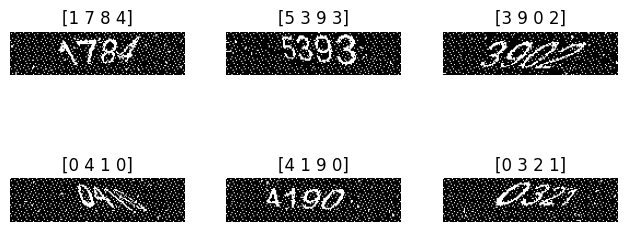

In [4]:
main_ds = create_dataset("/mnt/Data/ML/datasets/captchas-austria")
ds_size = main_ds.cardinality().numpy()
train_ds = main_ds.take(math.floor(ds_size * (1-test_split))) 
test_ds = main_ds.skip(math.floor(ds_size * (1-test_split)))

In [ ]:
loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=lr)
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_metric = keras.metrics.CategoricalAccuracy(name='train_accuracy')


def make_encoder() :
    input_layer = keras.layers.Input(shape=image_shape)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    
    x = keras.layers.Flatten(name='flatten_after_convs')(x)
    x = keras.layers.Dense(768, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(code_length * charset_length, activation='softmax')(x)
    output_layer = keras.layers.Reshape((code_length, charset_length), name='final_reshape')(output_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=optimizer, # type: ignore
              loss=loss_fn,
              metrics=[train_acc_metric])
    
    model.summary()
    return model

model = make_encoder()

In [ ]:
print(model.input_shape)
print(model.output_shape)
print(model.dtype)

get_shape(train_ds)

In [ ]:

# tf.config.run_functions_eagerly(False)
# tf.debugging.set_log_device_placement(True)
# model.fit(train_ds, epochs=30, validation_split=0.05)
num_images = train_ds.unbatch().cardinality().numpy() * (1 - validation_split)
print(num_images)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                                initial_sparsity=0.50,
                                final_sparsity=0.80,
                                begin_step=0,
                                end_step=end_step)
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

In [24]:
def evaluate_model_visual(model, test_dataset:tf.data.Dataset):
    loss, accuracy = model.evaluate(test_dataset)
    
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        
        plt.figure(figsize=(12, 8))  # Adjust figure size for better display
        for i in range(len(images)):
            true_label = labels[i].numpy()
            pred_label = tf.nn.softmax(predictions[i]).numpy()
            
            # Get predicted and true label indices
            pred_label_indices = np.argmax(pred_label, axis=-1)
            true_label_indices = np.argmax(true_label, axis=-1)
            
            # Subplot with 3 images per row
            plt.subplot(len(images) // 3 + 1, 3, i + 1)
            plt.imshow(images[i].numpy().reshape(image_shape[:2]), cmap='gray')
            plt.title(f"True: {true_label_indices}, Pred: {pred_label_indices}")
            plt.axis('off')  # Hide axes for better visualization
        
        plt.tight_layout()
        plt.show()

In [ ]:
evaluate_model_visual(model, test_ds)

In [27]:
model.save(filepath="mame.keras")

In [ ]:
# onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)

In [180]:
import onnxruntime as ort
def eval_onnx(model : ort.InferenceSession, test_dataset: tf.data.Dataset):
    
    total_time = 0
    correct_predictions = 0 
    total_samples = test_dataset.cardinality().numpy() * batch_size

    for batch_images, batch_labels in test_ds.as_numpy_iterator():
        # print(batch_images.shape)
        start_time = time.process_time()
        outputs = ort_session.run(None, {'image': batch_images})
        end_time = time.process_time()
        total_time += (end_time - start_time)
        for i in range(len(outputs[0])):
            pred = np.argmax(outputs[0][i], axis = 1)
            truth = np.argmax(batch_labels[i], axis = 1)
            if (np.array_equal(pred, truth)):
                correct_predictions+=1
            else :
                print(pred)
                print(truth)
    
    accuracy = correct_predictions / total_samples
    average_inference_time = total_time / total_samples

    print(f"Test DS Accuracy: {accuracy} with {total_samples} samples",)
    print(f"Average Inference Time: {average_inference_time} seconds")

ort_session = ort.InferenceSession('mame.onnx')
eval_onnx(ort_session,test_ds)

[6 7 3 6]
[6 7 5 6]
[7 3 3 6]
[7 3 6 6]
[8 1 6 6]
[8 1 6 3]
Test DS Accuracy: 0.9994066455696202 with 5056 samples
Average Inference Time: 0.004846640739715157 seconds
